In [1]:
from GenStudentMixtures.GenStudentMixtures import GenStudentMixtures
from GenStudentMixtures.Mixture_Multivariate_Student_Generalized import MMST

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix


import numpy as np

import matplotlib.pyplot as plt

## Utils

In [2]:
def amari_distance(W, A):
    P = W@A
    def s(r):
        return np.sum(np.sum(r ** 2, axis=1) / np.max(r ** 2, axis=1) - 1)

    return (s(np.abs(P)) + s(np.abs(P.T))) / (2 * P.shape[0])

## Sampling

### 3 clusters dim 2

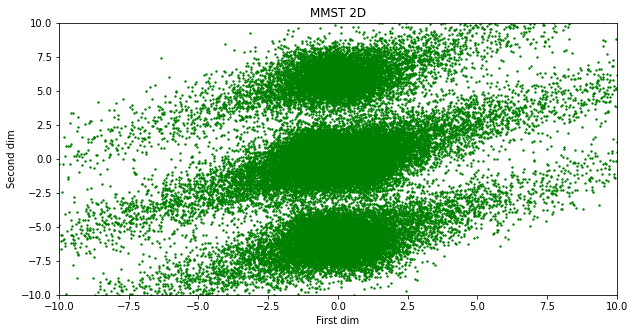

In [3]:
π_23 = np.array([.3, .5, .2], dtype=np.float64)
μ_23 = np.array([[0, -6], [0, 0], [0, 6]], dtype=np.float64)
angle = np.pi / 6
matRot_23 = [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
D_23 = np.array([matRot_23, matRot_23, matRot_23], dtype=np.float64)
A_23 = np.ones((3, 2), dtype=np.float64)
ν_23 = np.array([[1, 30], [1, 30], [1, 30]], dtype=np.float64)

gen_mix_23 = MMST(π_23, μ_23, A_23, D_23, ν_23).sample(50000)
key = lambda e: abs(e[0].max()) < 10 and abs(e[0].min()) < 10
gen_mix_23 = np.array(sorted(gen_mix_23, key=lambda e: abs(e.max()) < 10 and abs(e.min()) < 10)[::-1], dtype=np.float64)


plt.figure(figsize=(10, 5))

plt.scatter(gen_mix_23[:, 0], gen_mix_23[:, 1], s=1.9, c='green')

plt.xlim(-10, 10)
plt.xlabel('First dim')

plt.ylim(-10, 10)
plt.ylabel('Second dim')

plt.title('MMST 2D')
plt.show()

In [5]:
# real estimation 
model = KMeans(3, max_iter=3000, tol=1e-5)
gen_mix_init = gen_mix_23[:500]
model.fit(gen_mix_init)

π_pred = np.array([(model.labels_ == k).sum() / len(model.labels_) for k in range(3)], dtype=np.float64)
μ_pred = np.array([gen_mix_init[model.labels_ == k].mean(0) for k in range(3)], dtype=np.float64)
D_pred = np.array([np.eye(2), np.eye(2), np.eye(2)], dtype=np.float64)
A_pred = np.ones(A_23.shape, dtype=np.float64)
ν_pred = 30 * np.ones(ν_23.shape, dtype=np.float64)

model = GenStudentMixtures(π_pred, μ_pred, A_pred, D_pred, ν_pred)
model.fit(gen_mix_23)

cluster_lab = model.predict(gen_mix_23)

cdict = {0: 'red', 1: 'blue', 2: 'green'}

fig = plt.figure(figsize=(10, 5))

for g in np.unique(cluster_lab):
    ix = np.where(cluster_lab == g)
    plt.scatter(gen_mix_23[:,0][ix], gen_mix_23[:,1][ix], c = cdict[int(g)], label = int(g), s = 1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title('Clustering 3 clusters dim 2')

plt.show()

 43%|█████████████████▍                       | 425/999 [00:47<01:04,  8.92it/s]


KeyboardInterrupt: 

In [ ]:
print(model.pi, π_23)

In [ ]:
permut_real2model = [0, 2, 1]

In [ ]:
pi_curve = [np.linalg.norm(pi[permut_real2model] - π_23, 2) for pi in model.pi_hist] 

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(pi_curve)), pi_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\pi - \pi_{true}||_2$ ')
plt.show()

In [ ]:
mu_curve = np.array([[np.linalg.norm(mu[permut_real2model][k]-μ_23[k], 2) for k in range(3)] for mu in model.mu_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(mu_curve)), mu_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\mu - \mu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
tmp = np.swapaxes(model.D, 1, 2) @ D_23 / np.max(np.abs(np.swapaxes(model.D, 1, 2) @ D_23),
                                                         axis=-1)[..., np.newaxis]
permute = np.logical_or(tmp == 1, tmp == -1)

A_permut_hist = [(permute @ A[...,np.newaxis]).squeeze(-1) for A in model.A_hist]
nu_permut_hist = [(permute @ nu[...,np.newaxis]).squeeze(-1) for nu in model.nu_hist]
D_permut_hist = [(permute * np.sign(tmp)) @ D for D in model.D_hist]

In [ ]:
D_curve  = np.array([[np.linalg.norm(D[permut_real2model][k] - D_23[k], ord='fro') for k in range(3)] for D in D_permut_hist]).mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(D_curve)), D_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||D - D_{true}||_{Fro}$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
nu_curve = np.array([[np.linalg.norm(nu[permut_real2model][k]-ν_23[k], 2) for k in range(3)] for nu in nu_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(nu_curve)), nu_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\nu - \nu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
A_curve = np.array([[np.linalg.norm(A[permut_real2model][k]-A_23[k], 2) for k in range(3)] for A in A_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(A_curve)), A_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||A - A_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

### 4 clusters 2 dims

In [ ]:
π_24 = np.array([.1, .2, .3, .4], dtype=np.float64)
μ_24 = np.array([[0, -6], [0, 0], [0, 6], [-6, 6]], dtype=np.float64)
angle = np.pi / 6
matRot_24 = [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
D_24 = np.array([matRot_24, matRot_24, matRot_24, matRot_24], dtype=np.float64)
A_24 = np.ones((4, 2), dtype=np.float64)
ν_24 = np.array([[1, 30], [1, 30], [1, 30], [1, 30]], dtype=np.float64)

gen_mix_24 = MMST(π_24, μ_24, A_24, D_24, ν_24).sample(100000)
gen_mix_24 = np.array(sorted(gen_mix_24, key=lambda e: abs(e.max()) < 10 and abs(e.min()) < 10)[::-1], dtype=np.float64)

plt.figure(figsize=(10, 5))

plt.scatter(gen_mix_24[:, 0], gen_mix_24[:, 1], s=1.9, c='green')

plt.xlim(-10, 10)
plt.xlabel('First dim')

plt.ylim(-10, 10)
plt.ylabel('Second dim')

plt.title('MMST 2D')
plt.show()

In [ ]:
# real estimation 
model = KMeans(4, max_iter=3000, tol=1e-5)
gen_mix_init = gen_mix_24[:500]
model.fit(gen_mix_init)

π_pred = np.array([(model.labels_ == k).sum() / len(model.labels_) for k in range(4)], dtype=np.float64)
μ_pred = np.array([gen_mix_init[model.labels_ == k].mean(0) for k in range(4)], dtype=np.float64)
D_pred = np.array([np.eye(2), np.eye(2), np.eye(2), np.eye(2)], dtype=np.float64)
A_pred = np.ones(A_24.shape, dtype=np.float64)
ν_pred = 30 * np.ones(ν_24.shape, dtype=np.float64)

model = GenStudentMixtures(π_pred, μ_pred, A_pred, D_pred, ν_pred)
model.fit(gen_mix_24, 50)

cluster_lab = model.predict(gen_mix_24)

cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'}

fig = plt.figure(figsize=(10, 5))

for g in np.unique(cluster_lab):
    ix = np.where(cluster_lab == g)
    plt.scatter(gen_mix_24[:,0][ix], gen_mix_24[:,1][ix], c = cdict[int(g)], label = int(g), s = 1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title('Clustering 4 clusters dim 2')
plt.show()

In [ ]:
print(model.pi, π_24)

In [ ]:
permut_real2model = [1, 3, 0, 2]

In [ ]:
pi_curve = [np.linalg.norm(pi[permut_real2model] - π_24, 2) for pi in model.pi_hist] 

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(pi_curve)), pi_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\pi - \pi_{true}||_2$ ')
plt.show()

In [ ]:
mu_curve = np.array([[np.linalg.norm(mu[permut_real2model][k]-μ_24[k], 2) for k in range(4)] for mu in model.mu_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(mu_curve)), mu_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\mu - \mu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
tmp = np.swapaxes(model.D, 1, 2) @ D_24 / np.max(np.abs(np.swapaxes(model.D, 1, 2) @ D_24),
                                                         axis=-1)[..., np.newaxis]
permute = np.logical_or(tmp == 1, tmp == -1)

A_permut_hist = [(permute @ A[...,np.newaxis]).squeeze(-1) for A in model.A_hist]
nu_permut_hist = [(permute @ nu[...,np.newaxis]).squeeze(-1) for nu in model.nu_hist]
D_permut_hist = [(permute * np.sign(tmp)) @ D for D in model.D_hist]

In [ ]:
D_curve  = np.array([[np.linalg.norm(D[permut_real2model][k] - D_24[k], ord='fro') for k in range(4)] for D in D_permut_hist]).mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(D_curve)), D_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||D - D_{true}||_{Fro}$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
nu_curve = np.array([[np.linalg.norm(nu[permut_real2model][k]-ν_24[k], 2) for k in range(4)] for nu in nu_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(nu_curve)), nu_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\nu - \nu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
A_curve = np.array([[np.linalg.norm(A[permut_real2model][k]-A_24[k], 2) for k in range(4)] for A in A_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(A_curve)), A_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||A - A_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

### 3 clusters 3 dims

In [ ]:
#3D mixtures
π_33 = np.array([.3, .5, .2], dtype=np.float64)
μ_33 = np.array([[0, -6, 0], [0, 0, 0], [0, 6, 0]], dtype=np.float64)
angle = np.pi / 6
matRot_33 = [[1, 0, 0], [0, np.cos(angle), -np.sin(angle)], [0, np.sin(angle), np.cos(angle)]]
D_33 = np.array([matRot_33, matRot_33, matRot_33], dtype=np.float64)
A_33 = np.ones((3, 3), dtype=np.float64)
ν_33 = np.array([[1, 10, 30], [1, 10, 30], [1, 10, 30]], dtype=np.float64)

gen_mix_33 = MMST(π_33, μ_33, A_33, D_33, ν_33).sample(30000)
gen_mix_33 = np.array(sorted(gen_mix_33, key=lambda e: abs(e.max()) < 10 and abs(e.min()) < 10)[::-1], dtype=np.float64)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(gen_mix_33[:, 0], gen_mix_33[:, 1], gen_mix_33[:, 2], s=1, c='green')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)

ax.set_title("MMST 3D")

ax.set_xlabel("First dim")
ax.set_ylabel("Second dim")
ax.set_zlabel("Third dim")

plt.show()

In [ ]:
model = KMeans(3, max_iter=3000, tol=1e-5)
gen_mix_init = gen_mix_33[:500]
model.fit(gen_mix_init)

π_pred = np.array([(model.labels_ == k).sum() / len(model.labels_) for k in range(3)], dtype=np.float64)
μ_pred = np.array([gen_mix_init[model.labels_ == k].mean(0) for k in range(3)], dtype=np.float64)
D_pred = np.array([np.eye(3), np.eye(3), np.eye(3)], dtype=np.float64)
A_pred = np.ones(A_33.shape, dtype=np.float64)
ν_pred = 30 * np.ones(ν_33.shape, dtype=np.float64)

model = GenStudentMixtures(π_pred, μ_pred, A_pred, D_pred, ν_pred)
model.fit_batch(gen_mix_33)

cluster_lab = model.predict(gen_mix_33)

cdict = {0: 'red', 1: 'blue', 2: 'green'}

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')
for g in np.unique(cluster_lab):
    ix = np.where(cluster_lab == g)
    ax.scatter(gen_mix_33[:,0][ix], gen_mix_33[:,1][ix], gen_mix_33[:,2][ix], c = cdict[int(g)], label = int(g), s = 1)
ax.legend()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_title('Clustering 3 clusters dim 3')

plt.show()

In [ ]:
print(model.pi, π_33)

In [ ]:
permut_real2model = [0, 2, 1]

In [ ]:
pi_curve = [np.linalg.norm(pi[permut_real2model] - π_33, 2) for pi in model.pi_hist] 

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(pi_curve)), pi_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\pi - \pi_{true}||_2$ ')
plt.show()

In [ ]:
mu_curve = np.array([[np.linalg.norm(mu[permut_real2model][k]-μ_33[k], 2) for k in range(3)] for mu in model.mu_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(mu_curve)), mu_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\mu - \mu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
permut_sign = np.round(np.swapaxes(model.D, 1, 2) @ D_33)
permut = np.abs(permut_sign)

A_permut_hist = [(permut @ A[...,np.newaxis]).squeeze(-1) for A in model.A_hist]
nu_permut_hist = [(permut @ nu[...,np.newaxis]).squeeze(-1) for nu in model.nu_hist]
D_permut_hist = [permut_sign @ D for D in model.D_hist]

In [ ]:
D_curve  = np.array([[np.linalg.norm(D[permut_real2model][k] - D_33[k], ord='fro') for k in range(3)] for D in D_permut_hist]).mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(D_curve)), D_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||D - D_{true}||_{Fro}$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
nu_curve = np.array([[np.linalg.norm(nu[permut_real2model][k]-ν_33[k], 2) for k in range(3)] for nu in nu_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(nu_curve)), nu_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\nu - \nu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
A_curve = np.array([[np.linalg.norm(A[permut_real2model][k]-A_33[k], 2) for k in range(3)] for A in A_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(A_curve)), A_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||A - A_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
model.A

### 4 clusters 3 dims

In [ ]:
#3D mixtures
π_34 = np.array([.2, .3, .2, .3], dtype=np.float64)
μ_34 = np.array([[0, -6, 0], [0, 0, 0], [0, 6, 0], [6, 0, 0]], dtype=np.float64)
angle = np.pi / 6
matRot_34 = [[1, 0, 0], [0, np.cos(angle), -np.sin(angle)], [0, np.sin(angle), np.cos(angle)]]
D_34 = np.array([matRot_34, matRot_34, matRot_34, matRot_34], dtype=np.float64)
A_34 = np.ones((4, 3), dtype=np.float64)
ν_34 = np.array([[1, 10, 30], [1, 10, 30], [1, 10, 30], [1, 10, 30]], dtype=np.float64)

gen_mix_34 = MMST(π_34, μ_34, A_34, D_34, ν_34).sample(4000)
gen_mix_34 = np.array(sorted(gen_mix_34, key=lambda e: abs(e.max()) < 10 and abs(e.min()) < 10)[::-1], dtype=np.float64)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(gen_mix_34[:, 0], gen_mix_34[:, 1], gen_mix_34[:, 2], s=1, c='green')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)

ax.set_title("MMST 3D")

ax.set_xlabel("First dim")
ax.set_ylabel("Second dim")
ax.set_zlabel("Third dim")

plt.show()

In [ ]:
model = KMeans(4, max_iter=3000, tol=1e-5)
gen_mix_init = gen_mix_34[:500]
model.fit(gen_mix_init)

π_pred = np.array([(model.labels_ == k).sum() / len(model.labels_) for k in range(4)], dtype=np.float64)
μ_pred = np.array([gen_mix_init[model.labels_ == k].mean(0) for k in range(4)], dtype=np.float64)
D_pred = np.array([np.eye(3), np.eye(3), np.eye(3), np.eye(3)], dtype=np.float64)
A_pred = np.ones(A_34.shape, dtype=np.float64)
ν_pred = 30 * np.ones(ν_34.shape, dtype=np.float64)

model = GenStudentMixtures(π_pred, μ_pred, A_pred, D_pred, ν_pred)
model.fit(gen_mix_34)

cluster_lab = model.predict(gen_mix_34)

cdict = {0: 'red', 1: 'blue', 2: 'green', 3:'orange'}

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')

for g in np.unique(cluster_lab):
    ix = np.where(cluster_lab == g)
    ax.scatter(gen_mix_34[:,0][ix], gen_mix_34[:,1][ix], gen_mix_34[:,2][ix], c = cdict[int(g)], label = int(g), s = 1)
ax.legend()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_title('Clustering 4 clusters dim 3')

plt.show()

In [ ]:
print(model.pi, π_34)

In [ ]:
permut_real2model = [2, 1, 0, 3]

In [ ]:
pi_curve = [np.linalg.norm(pi[permut_real2model] - π_34, 2) for pi in model.pi_hist] 

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(pi_curve)), pi_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\pi - \pi_{true}||_2$ ')
plt.show()

In [ ]:
mu_curve = np.array([[np.linalg.norm(mu[permut_real2model][k]-μ_34[k], 2) for k in range(4)] for mu in model.mu_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(mu_curve)), mu_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\mu - \mu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
D_curve  = np.array([[amari_distance(D[permut_real2model][k], D_34[k]) for k in range(4)] for D in model.D_hist]).mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(D_curve)), D_curve)
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$Amari(D - D_{true})$ (moyenne prise sur le nombre de cluster)')
plt.show()